# Восстановление золота из руды

Необходимо подготовить прототип модели машинного обучения для компании «Цифры», которая разрабатывает решения для эффективной работы промышленных предприятий.
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. У нас есть данные с параметрами добычи и очистки.
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

В процессе выполнения проекта необходимо:

- Подготовить данные;
- Провести исследовательский анализ данных;
- Построить и обучить модель.

***Технологический процесс***

Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.


**Стадии:**

1. Флотация

Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).

2. Очистка

Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.


***Описание данных***

**Технологический процесс**

* `Rougher feed` — исходное сырье
* `Rougher additions` (или `reagent additions`) — флотационные реагенты: Xanthate, Sulphate, Depressant
    * `Xanthat **` — ксантогенат (промотер, или активатор флотации);
    * `Sulphate` — сульфат (на данном производстве сульфид натрия);
    * `Depressant` — депрессант (силикат натрия).
* `Rougher process` (англ. «грубый процесс») — флотация
* `Rougher tails` — отвальные хвосты
* `Float banks` — флотационная установка
* `Cleaner process` — очистка
* `Rougher Au` — черновой концентрат золота
* `Final Au` — финальный концентрат золота

**Параметры этапов**

* `air amount` — объём воздуха
* `fluid levels` — уровень жидкости
* `feed size` — размер гранул сырья
* `feed rate` — скорость подачи


**Наименование признаков**

Наименование признаков должно быть такое:
`[этап].[тип_параметра].[название_параметра]`

Пример: `rougher.input.feed_ag`
Возможные значения для блока `[этап]`:

- `rougher` — флотация
- `primary_cleaner` — первичная очистка
- `secondary_cleaner` — вторичная очистка
- `final` — финальные характеристики

Возможные значения для блока `[тип_параметра]`:

- `input` — параметры сырья
- `output` — параметры продукта
- `state` — параметры, характеризующие текущее состояние этапа
- `calculation` — расчётные характеристики


Нужно спрогнозировать сразу две величины:

1. эффективность обогащения чернового концентрата `rougher.output.recovery`;
2. эффективность обогащения финального концентрата `final.output.recovery`.


Данные находятся в трёх файлах:

* `gold_recovery_train_new_8ds.csv` — обучающая выборка;
* `gold_recovery_test_new_8ds.csv` — тестовая выборка;
* `gold_recovery_full_new_8ds.csv` — исходные данные.

Данные индексируются датой и временем получения информации (признак `date`). Соседние по времени параметры часто похожи.

Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.

Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

Данные сырые. Необхоима их проверка и предобработка.

## Загрузка и подготовка данных

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important; }</style>"))

***Выгрузка библиотек***

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set();

from sklearn.metrics import mean_absolute_error

***Константы***

In [3]:
RANDOM_SEED = 0

In [4]:
# Based on: https://stackoverflow.com/a/17303428 (для красивого оформления текста)
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

***Функции***

In [5]:
#Рандоманая выгрузка строк
show_sample = lambda x: display(x.sample(5, random_state=RANDOM_SEED).reset_index(drop=True))

In [6]:
def com_info(data):
    '''
    Функция для изучения общей информации: input: data
                                           output: - вывод рандомных строк,
                                                   - типов данных,
                                                   - % пропусков
                                                   - статистики
                                                   - наличие дубликатов
                                                   - размерность данных
                                                   
    '''
    name = [x for x in globals() if globals()[x] is data][0]
    print(color.UNDERLINE + 'Общая информация по данным '+ name + color.END)
    show_sample(data)
    print(data.info(memory_usage=True))
    display(pd.DataFrame(round((data.isna().mean()), 2)).style.background_gradient('coolwarm')\
                                                                .set_caption('% пропусков').format({0:'{:.2%}'.format}))
    display(data.describe().T.style.set_caption('Статистика'))
    print('Количество дублей: ', data.duplicated().sum())
    print('Количество строк: ', data.shape[0], ', количество столбцов: ', data.shape[1])
    print('******************************************************************')
    print('')

In [7]:
def downcast_func(data):
    name = [x for x in globals() if globals()[x] is data][0]
    print(color.UNDERLINE + 'Информация по типам данных '+ name + color.END)
    float_features = data.select_dtypes(include='float').columns
    data[float_features] = data[float_features].apply(pd.to_numeric, downcast='float')
    print(data.info(memory_usage=True))

In [8]:
def checking_of_effectiveness_calc(C, F, T, RougherOutputRecoveryAct):
    '''
    Функция для проверки эффективности:
    Input:
    C — доля золота в концентрате после флотации/очистки;
    F — доля золота в сырье/концентрате до флотации/очистки;
    T — доля золота в отвальных хвостах после флотации/очистки.
    Output: MAE
    '''
    RougherOutputRecoveryCalc = (C*(F-T))/(F*(C-T))*100
    return mean_absolute_error(RougherOutputRecoveryAct, RougherOutputRecoveryCalc)    

***Загрузка данных***

In [9]:
df_train = pd.read_csv('../datasets/gold_recovery_train_new_8ds.csv')
df_test = pd.read_csv('../datasets/gold_recovery_test_new_8ds.csv')
df_full = pd.read_csv('../datasets/gold_recovery_full_new_8ds.csv')

## Подготовка данных

### 1.1. Изучение общей информации

In [10]:
df_list = [df_train, df_test, df_full]
for i in df_list:
    com_info(i)

Общая информация по данным df_train


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2018-06-08 12:59:59,4.068389,11.448127,5.983031,45.728369,63.185926,7.436988,2.577877,10.211517,2.042844,99.732267,7.252426,6.825,0.702993,5.747566,13.588954,7.378889,34.649302,17.597198,4.702111,6.517120,2.368953,1603.268907,-500.115801,1471.571680,-499.576251,1602.685484,-499.972861,1027.751721,-500.811690,42913.665507,2785.559395,2785.149436,1.318954,5.969035,3.907571,499.626977,70.977362,40.129088,5.153906,7.387563,5.597894,7.386242,5.612319,11.436856,11.132484,28.501758,16.771833,90.669868,3.317203,0.288877,18.156484,0.666596,1197.020398,-299.987078,1202.540003,-500.426514,1202.957760,-499.831297,1099.868778,-500.408752,1000.158975,-499.684249,1000.345311,-500.801754,15.455878,11.476563,NaN,5.244986,36.009503,-500.230128,30.014005,-499.948950,37.007576,-500.146875,27.975799,-499.881781,30.026765,-485.043326,22.022924,-466.815927,25.026081,-495.662399,21.919914,-500.075170,24.989364,-501.420340
1,2016-06-24 08:59:59,4.672297,10.013952,8.417600,45.142223,70.512351,8.217110,1.566327,11.871072,2.433252,107.117324,5.006355,7.690,1.024347,8.001182,9.58721

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


,0
date,0.00%
final.output.concentrate_ag,0.00%
final.output.concentrate_pb,0.00%
final.output.concentrate_sol,1.00%
final.output.concentrate_au,0.00%
final.output.recovery,0.00%
final.output.tail_ag,0.00%
final.output.tail_pb,1.00%
final.output.tail_sol,0.00%
final.output.tail_au,0.00%


,count,mean,std,min,25%,50%,75%,max
final.output.concentrate_ag,14148.000000,5.142034,1.369586,0.000000,4.211620,4.994652,5.859540,16.001945
final.output.concentrate_pb,14148.000000,10.132960,1.654930,0.000000,9.297355,10.297144,11.170603,17.031899
final.output.concentrate_sol,13938.000000,9.202849,2.790516,0.000000,7.484645,8.845462,10.487508,18.124851
final.output.concentrate_au,14149.000000,44.003792,4.905261,0.000000,43.276111,44.872436,46.166425,52.756638
final.output.recovery,14149.000000,66.518832,10.295402,0.000000,62.545817,67.432775,72.346428,100.000000
final.output.tail_ag,14149.000000,9.607035,2.319069,0.000000,7.997429,9.480270,11.003707,19.552149
final.output.tail_pb,14049.000000,2.597298,0.971843,0.000000,1.905973,2.592022,3.241723,5.639565
final.output.tail_sol,14144.000000,10.512122,3.003617,0.000000,8.811324,10.514621,11.933009,22.317730
final.output.tail_au,14149.000000,2.918421,0.903712,0.000000,2.368607,2.851025,3.434764,8.197408
primary_cleaner.input.sulfate,14129.000000,133.320659,39.431659,0.003112,107.006651,133.018328,159.825396,250.127834


Количество дублей:  0
Количество строк:  14149 , количество столбцов:  87
******************************************************************

Общая информация по данным df_test


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-02 05:59:59,126.329123,8.003034,7.160000,0.699695,1400.760536,-500.200817,1399.437375,-500.679938,1399.429209,-499.067140,1399.729437,-499.640771,8.010967,4.207135,500.255644,70.952990,42.962929,8.287757,9.992763,5.606571,9.996389,5.596976,1002.564947,-349.853857,1250.905440,-400.291238,1248.537193,-399.773792,1202.527563,-400.885184,1000.037743,-399.734051,950.184984,-400.978681,24.946197,-500.069905,11.895743,-499.623151,19.967564,-500.246133,11.982874,-500.073486,11.960962,-500.130469,7.924387,-500.362897,7.849120,-500.357611,4.983730,-500.111778,9.935444,-500.440997
1,2016-10-02 01:59:59,137.116643,3.972800,8.600000,0.803511,1598.994956,-500.061922,1603.985367,-499.302443,1600.063771,-500.351414,1598.782409,-499.950738,9.962656,3.759965,399.363090,43.614246,31.639175,9.747144,9.011997,6.397272,9.010591,6.402290,999.688435,-500.230344,1402.287885,-399.545665,1400.091239,-400.868293,1401.063480,-400.080883,1200.242579,-399.792161,1100.042026,-400.803842,22.011686,-500.194634,15.102800,-499.646809,23.003166,-499.698575,19.938329,-499.096309,12.015829,-580.205684,9.996712,-499.568551,10.029440,-500.834429,4.916034,-500.806331,20.014843,-499.598636
2,2016-10-05 16:59:59,136.160058,4.001874,7.700000,0.701256,1648.213302,-500.612006,1649.936185,-499.849197,1647.739364,-500.380169,1648.907802,-500.039132,10.475888,3.075634,457.442429,43.596812,35.593390,9.002293,10.996617,6.803472,10.973475,6.803706,1000.061137,-500.151099,1220.952457,-400.578894,1401.313346,-399.173436,1335.765356,-402.523428,1199.829269,-399.764540,1099.524470,-402.302027,25.069761,-499.446869,19.936174,-500.059276,24.937976,-499.172343,23.048603,-499.961325,13.988463,-498.835101,13.073075,-501.503654,10.127322,-498.489453,7.952812,-498.803034,22.987675,-500.658281
3,2017-10-31 11:59:59,220.706679,9.139982,7.040000,2.364929,1700.289848,-508.068208,1700.434596,-489.509097,1542.893209,-493.814645,1700.412672,-505.603329,12.644495,3.864685,632.129723,57.308352,43.332325,10.731736,17.016176,6.998575,17.025175,6.998296,1299.072182,-299.713460,1247.875349,-499.909747,1198.434360,-499.886905,1098.258641,-500.873555,1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

,0
date,0.00%
primary_cleaner.input.sulfate,0.00%
primary_cleaner.input.depressant,0.00%
primary_cleaner.input.feed_size,0.00%
primary_cleaner.input.xanthate,0.00%
primary_cleaner.state.floatbank8_a_air,0.00%
primary_cleaner.state.floatbank8_a_level,0.00%
primary_cleaner.state.floatbank8_b_air,0.00%
primary_cleaner.state.floatbank8_b_level,0.00%
primary_cleaner.state.floatbank8_c_air,0.00%


,count,mean,std,min,25%,50%,75%,max
primary_cleaner.input.sulfate,5286.000000,174.839652,43.027080,2.566156,147.121401,177.828489,208.125438,265.983123
primary_cleaner.input.depressant,5285.000000,8.683596,3.072050,0.003839,6.489555,8.052207,10.027764,40.000000
primary_cleaner.input.feed_size,5290.000000,7.266339,0.610219,5.650000,6.890000,7.250000,7.600000,15.500000
primary_cleaner.input.xanthate,5286.000000,1.383803,0.643474,0.004984,0.907623,1.197610,1.797819,4.102454
primary_cleaner.state.floatbank8_a_air,5290.000000,1539.494325,116.797884,0.000000,1498.935802,1585.129123,1602.076529,2103.103580
primary_cleaner.state.floatbank8_a_level,5290.000000,-497.665883,19.952431,-795.316337,-500.357298,-499.969164,-499.568951,-57.195404
primary_cleaner.state.floatbank8_b_air,5290.000000,1545.174232,122.224588,0.000000,1498.970993,1595.621798,1602.323545,1813.083671
primary_cleaner.state.floatbank8_b_level,5290.000000,-500.273098,32.968307,-799.997015,-500.703002,-500.028514,-499.293257,-142.527229
primary_cleaner.state.floatbank8_c_air,5290.000000,1527.272362,122.538034,0.000000,1473.229862,1549.594682,1601.143775,1715.053773
primary_cleaner.state.floatbank8_c_level,5290.000000,-498.330680,21.964876,-799.960571,-501.018117,-500.017711,-498.994130,-150.937035


Количество дублей:  0
Количество строк:  5290 , количество столбцов:  53
******************************************************************

Общая информация по данным df_full


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2017-02-08 14:59:59,5.295988,8.195301,13.379583,47.758663,65.280176,9.925318,3.387088,7.605304,3.382011,88.025736,8.082156,6.780000,1.349388,8.509287,7.432810,6.704215,33.850846,17.925953,3.713285,5.571651,3.788193,1794.481420,-350.265470,1799.470760,-350.491718,1798.338009,-351.657929,1538.980253,-349.106166,37855.335517,3107.930038,3107.466213,2.486664,8.419499,3.456962,391.128017,NaN,29.196869,8.596304,9.501066,5.699917,9.499393,5.700741,13.238094,7.467266,35.876975,24.887139,82.764867,6.059697,0.573929,11.876489,2.074698,1499.646078,-299.953656,1399.068872,-500.023359,1298.497113,-500.326487,1199.215979,-499.876276,999.566016,-500.533131,999.870553,-500.549211,15.811448,4.603052,6.923786,3.267344,33.999922,-339.998859,30.030993,-350.122742,36.972836,-500.594480,29.987487,-500.319561,24.937716,-499.827034,22.955855,-499.981726,23.018173,-499.465128,20.014626,-500.003639,24.991929,-599.773615
1,2016-10-29 13:59:59,3.020476,9.071122,16.816693,49.797229,63.724514,8.165338,3.167601,10.705567,3.591239,149.481074,9.316742,7.260000,0.804833,5.416631,10.64017

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


,0
date,0.00%
final.output.concentrate_ag,0.00%
final.output.concentrate_pb,0.00%
final.output.concentrate_sol,1.00%
final.output.concentrate_au,0.00%
final.output.recovery,0.00%
final.output.tail_ag,0.00%
final.output.tail_pb,1.00%
final.output.tail_sol,0.00%
final.output.tail_au,0.00%


,count,mean,std,min,25%,50%,75%,max
final.output.concentrate_ag,19438.000000,5.168470,1.372348,0.000000,4.251240,5.066094,5.895527,16.001945
final.output.concentrate_pb,19438.000000,9.978895,1.669240,0.000000,9.137262,10.102433,11.035769,17.031899
final.output.concentrate_sol,19228.000000,9.501224,2.787537,0.000000,7.722820,9.218961,10.947813,19.615720
final.output.concentrate_au,19439.000000,44.076513,5.129784,0.000000,43.402215,45.011244,46.275313,52.756638
final.output.recovery,19439.000000,67.050208,10.125840,0.000000,63.299712,68.172738,72.686642,100.000000
final.output.tail_ag,19438.000000,9.688589,2.328642,0.000000,8.062878,9.743623,11.134294,19.552149
final.output.tail_pb,19338.000000,2.705795,0.949077,0.000000,2.040119,2.748730,3.333216,5.804178
final.output.tail_sol,19433.000000,10.583728,2.868782,0.000000,8.938947,10.622456,12.104271,22.317730
final.output.tail_au,19439.000000,3.042467,0.922808,0.000000,2.461138,2.984909,3.571351,8.245022
primary_cleaner.input.sulfate,19415.000000,144.624774,44.464071,0.003112,114.107029,143.232103,175.075656,265.983123


Количество дублей:  0
Количество строк:  19439 , количество столбцов:  87
******************************************************************



#### Выводы

***df_train***

- Типы данных не оптимизированы, необходимо понизить разрядность признаков
- В данных есть пропуски, больше всего в признаке `secondary_cleaner.output.tail_sol` (11%). Пропусков в целевых признаках нет
- Некоторые признаки отрицательные - например, `primary_cleaner.state.floatbank8_b_level`, `primary_cleaner.state.floatbank8_c_level`, `rougher.state.floatbank10_a_level` и т.д.
- Полных дублей в данных нет
- Количество строк:  14149 , количество столбцов:  87



***df_test***

- Типы данных не оптимизированы, необходимо понизить разрядность признаков
- В данных небольшое количество пропусков по некоторым признакам - например `rougher.input.feed_sol ` , `rougher.input.floatbank11_sulfate` (меньше 1%)
- Некоторые признаки отрицательные - например, `primary_cleaner.state.floatbank8_a_level`, `rougher.state.floatbank10_b_level` и т.д.
- Полных дублей в данных нет.
- Количество строк:  5290 , количество столбцов:  53

***df_full***

- Типы данных не оптимизированы, необходимо понизить разрядность признаков
- В данных есть пропуски, больше всего в признаке  `secondary_cleaner.output.tail_sol `  (9%). Пропусков в целевых признаках нет
- Некоторые признаки отрицательные - например, `primary_cleaner.state.floatbank8_a_level`, `rougher.state.floatbank10_b_level` и т.д.
- Полных дублей в данных нет
- Количество строк:  19439 , количество столбцов:  87

***Оптимизация типов данных***

In [11]:
for i in df_list:
     downcast_func(i)

Информация по типам данных df_train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float32
 2   final.output.concentrate_pb                         14148 non-null  float32
 3   final.output.concentrate_sol                        13938 non-null  float32
 4   final.output.concentrate_au                         14149 non-null  float32
 5   final.output.recovery                               14149 non-null  float32
 6   final.output.tail_ag                                14149 non-null  float32
 7   final.output.tail_pb                                14049 non-null  float32
 8   final.output.tail_sol                   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float32
 2   final.output.concentrate_pb                         19438 non-null  float32
 3   final.output.concentrate_sol                        19228 non-null  float32
 4   final.output.concentrate_au                         19439 non-null  float32
 5   final.output.recovery                               19439 non-null  float32
 6   final.output.tail_ag                                19438 non-null  float32
 7   final.output.tail_pb                                19338 non-null  float32
 8   final.output.tail_sol                               19433 non-null  float32


***Перевод дат в формат даты***

In [12]:
for i in df_list:
     i['date'] =  pd.to_datetime(i['date'], format='%Y-%m-%d %H:%M:%S')

### 1.2. Проверка того, что эффективность обогащения рассчитана правильно для признака rougher.output.recovery. Поиск MAE между расчётами и значением признака. 

In [13]:
MAE = checking_of_effectiveness_calc(df_full['rougher.output.concentrate_au'],
                                    df_full['rougher.input.feed_au'],
                                    df_full['rougher.output.tail_au'],
                                    df_full['rougher.output.recovery'])
print(f'MAE между расчетами и значением признака rougher.output.recovery: {MAE:.6f}')

MAE между расчетами и значением признака rougher.output.recovery: 0.000004


Расхождения небольшие, ошибка мала, что означает - наши данные корректны.

### 1.3. Анализ признаков, недоступных в тестовой выборке. 

In [14]:
df_train.columns.difference(df_test.columns)

Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'roughe

Видим, что в тестовой выборке отсутствует часть признаков, в том числе и целевых. Данные признаки являются расчетными и выходными характеристиками процессов.
Возможно их нет потому что их можно получить только после завершения технологического процеса.

Для предсказаний важно удалить отсутствующие в тестовом датафрейме признаки (кроме целевых) из нашего тренировочного датафрейма.

### 1.4. Проведение предобработки данных.

Выше мы анализировали количество пропусков и пришли к выводу, что их немного - зачастую меньше 1%.
Для обучения модели нам необходимо чтобы пропуски были заполнены. Т.к. данные содержат информацию о последовательных технологических процессах, мы можем заполнить пропуски предудущими значениями из выборки.

In [15]:
for i in df_list:
    name = [x for x in globals() if globals()[x] is i][0]
    i = i.fillna(method='ffill')
    print(f'Проверка пропусков для данных {name}: {i.isnull().sum().sum()}' )

Проверка пропусков для данных df_train: 0
Проверка пропусков для данных df_test: 0
Проверка пропусков для данных df_full: 0


### Выводы

Краткая информация по имеющимся даннм:

***df_train***

- Типы данных не оптимизированы, необходимо понизить разрядность признаков
- В данных есть пропуски, больше всего в признаке `secondary_cleaner.output.tail_sol` (11%). Пропусков в целевых признаках нет
- Некоторые признаки отрицательные - например, `primary_cleaner.state.floatbank8_b_level`, `primary_cleaner.state.floatbank8_c_level`, `rougher.state.floatbank10_a_level` и т.д.
- Полных дублей в данных нет
- Количество строк:  14149 , количество столбцов:  87



***df_test***

- Типы данных не оптимизированы, необходимо понизить разрядность признаков
- В данных небольшое количество пропусков по некоторым признакам - например `rougher.input.feed_sol ` , `rougher.input.floatbank11_sulfate` (меньше 1%)
- Некоторые признаки отрицательные - например, `primary_cleaner.state.floatbank8_a_level`, `rougher.state.floatbank10_b_level` и т.д.
- Полных дублей в данных нет.
- Количество строк:  5290 , количество столбцов:  53

***df_full***

- Типы данных не оптимизированы, необходимо понизить разрядность признаков
- В данных есть пропуски, больше всего в признаке  `secondary_cleaner.output.tail_sol `  (9%). Пропусков в целевых признаках нет
- Некоторые признаки отрицательные - например, `primary_cleaner.state.floatbank8_a_level`, `rougher.state.floatbank10_b_level` и т.д.
- Полных дублей в данных нет
- Количество строк:  19439 , количество столбцов:  87
        
        
Мы осуществили понижение разрядности данных для оптимизации работы кода.

Проверили, что эффективность обогащения рассчитана правильно для признака `rougher.output.recovery`. MAE между расчетами и значением признака rougher.output.recovery: 0.000004

Расхождения небольшие, ошибка мала, что означает - наши данные корректны.


В тестовой выборке отсутствует часть признаков, в том числе и целевых. Данные признаки являются расчетными и выходными характеристиками процессов. Возможно их нет потому что их можно получить только после завершения технологического процеса.

Для предсказаний важно удалить отсутствующие в тестовом датафрейме признаки (кроме целевых) из нашего тренировочного датафрейма.

Пропусков в данных немного - зачастую меньше 1%. Для обучения модели нам необходимо чтобы пропуски были заполнены. Т.к. данные содержат информацию о последовательных технологических процессах, мы заполнили пропуски предудущими значениями из выборки.


## Анализ данных

### 2.1. Как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

Посмотрим названия полей, которые потенциально нам могут подойти для визуализации концентрации металла:

In [16]:
print('Золото: \n', df_full.columns[df_full.columns.str.contains(pat = 'au')])
print('**********************************************************************')
print('Серебро: \n', df_full.columns[df_full.columns.str.contains(pat = 'ag')])
print('**********************************************************************')
print('Свинец: \n', df_full.columns[df_full.columns.str.contains(pat = 'pb')])

Золото: 
 Index(['final.output.concentrate_au', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.input.feed_au',
       'rougher.output.concentrate_au', 'rougher.output.tail_au',
       'secondary_cleaner.output.tail_au'],
      dtype='object')
**********************************************************************
Серебро: 
 Index(['final.output.concentrate_ag', 'final.output.tail_ag',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.tail_ag', 'rougher.input.feed_ag',
       'rougher.output.concentrate_ag', 'rougher.output.tail_ag',
       'secondary_cleaner.output.tail_ag'],
      dtype='object')
**********************************************************************
С

Нас интересуют следующие поля:
    
- rougher.input.feed
- rougher.output.concentrate
- primary_cleaner.output.concentrate
- final.output.concentrate

Таким образом, нам необходимо простроить гистограммы распределения концентрации по каждому металлу: Au, Ag, Pb

In [17]:
steps = ['rougher.input.feed_{}', 'rougher.output.concentrate_{}', 'primary_cleaner.output.concentrate_{}', 
         'final.output.concentrate_{}']

metals = ['au', 'ag', 'pb']

def concentration_change_charts(metal):
    '''
    Функция для построения визуализации (гистограмм) изменения концентрации металлов
    input: Название металла
    output: Построение гистограмм
    
    '''
    step_name = [s.format(metal) for s in steps]    
    plt.figure(figsize=(10, 3))
    for step in step_name:
        df_full[step].hist(bins=20, alpha=0.7)
        plt.legend(step_name)
        plt.title(f'Изменение концентрации {metal}', size = 17, fontweight="bold")
        plt.xlabel('Концентрация')
        plt.ylabel('Частота')

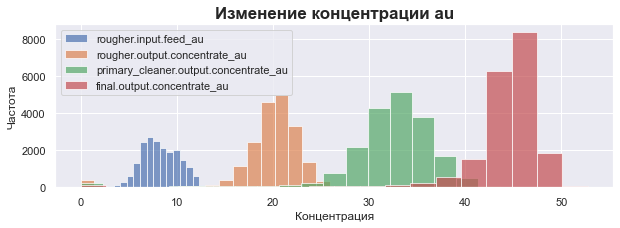

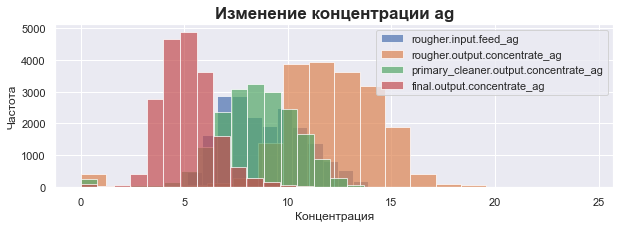

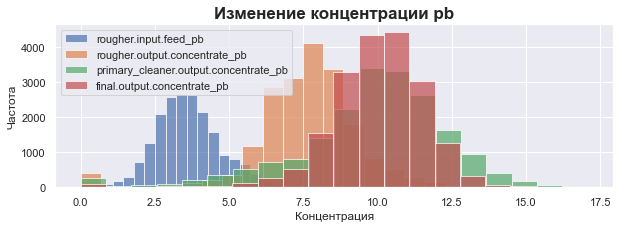

In [18]:
for m in metals:
    concentration_change_charts(m)

**Золото**

На каждом последующем этапе обработки золота по графику видим, что концентрация золота растет. Также по графику заметно, что в данных есть выбросы, например, концентрация равная 0.

**Серебро**

По гистограммам можно увидеть, что на этапе флотации концентрация серебра растет, а на этапе очистки падает. На финальном этапе концентрация наиболее высокая. Также по гистограмме можно сказать, что в данных есть выбросы. Концентрация серебра не может быть равной 0.

**Свинец**

Концентрация свинца также растет на всех этапах. Наиболее стремительно - на этапе флотации. На графике можно заметить выбросы на всех этапах очистки - 0 значения концентрации.

### 2.2. Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

In [19]:
print(color.UNDERLINE + 'Поля, содержащие размер гранул сырья в обучающающей выборке'+ color.END)
print(df_train.columns[df_train.columns.str.contains(pat = 'feed_size')])
print('')
print(color.UNDERLINE + 'Поля, содержащие размер гранул сырья в тестовой выборке'+ color.END)
print(df_test.columns[df_test.columns.str.contains(pat = 'feed_size')])

Поля, содержащие размер гранул сырья в обучающающей выборке
Index(['primary_cleaner.input.feed_size', 'rougher.input.feed_size'], dtype='object')

Поля, содержащие размер гранул сырья в тестовой выборке
Index(['primary_cleaner.input.feed_size', 'rougher.input.feed_size'], dtype='object')


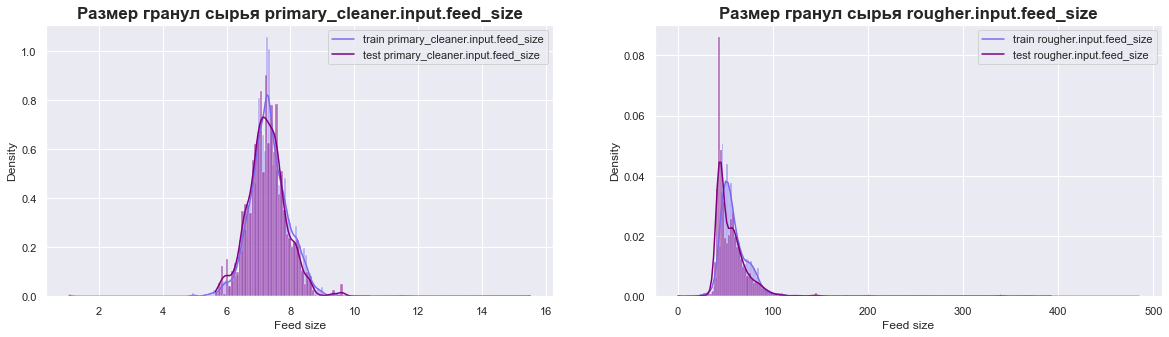

In [20]:
plt.subplots(figsize = (20, 5))

plt.subplot(1, 2, 1)
plt.title('Размер гранул сырья primary_cleaner.input.feed_size', size = 17, fontweight="bold")
sns.histplot(df_train['primary_cleaner.input.feed_size'], kde=True, common_norm=True, stat="density", color='mediumslateblue')
sns.histplot(df_test['primary_cleaner.input.feed_size'], kde=True, common_norm=True, stat="density", color='purple')
plt.xlabel('Feed size')
plt.ylabel('Density')
plt.legend(['train primary_cleaner.input.feed_size', 'test primary_cleaner.input.feed_size'])


plt.subplot(1, 2, 2)
plt.title('Размер гранул сырья rougher.input.feed_size', size = 17, fontweight="bold")
sns.histplot(df_train['rougher.input.feed_size'], kde=True, common_norm=True, stat="density", color='mediumslateblue')
sns.histplot(df_test['rougher.input.feed_size'], kde=True, common_norm=True, stat="density", color='purple')
plt.xlabel('Feed size')
plt.ylabel('Density')
plt.legend(['train rougher.input.feed_size', 'test rougher.input.feed_size'])
plt.show()

Распределения в обоих выборках схожи между собой, поэтому данные можно использовать для построения моделей. 

In [21]:
steps = df_train.columns[df_train.columns.str.contains(pat = 'feed_size')]
for s in steps:
    print('Статистика гранул сырья тренировочной выборки')
    print(df_train[s].describe())
    print("*************************")
    print('Статистика гранул сырья тестовой выборки')
    print(df_test[s].describe())

Статистика гранул сырья тренировочной выборки
count    14149.000000
mean         7.322204
std          0.614060
min          1.080000
25%          6.960000
50%          7.290000
75%          7.700000
max         10.470000
Name: primary_cleaner.input.feed_size, dtype: float64
*************************
Статистика гранул сырья тестовой выборки
count    5290.000000
mean        7.266315
std         0.610219
min         5.650000
25%         6.890000
50%         7.250000
75%         7.600000
max        15.500000
Name: primary_cleaner.input.feed_size, dtype: float64
Статистика гранул сырья тренировочной выборки
count    14005.000000
mean        60.110500
std         22.418486
min          9.659576
25%         48.973026
50%         55.373886
75%         66.080170
max        484.967468
Name: rougher.input.feed_size, dtype: float64
*************************
Статистика гранул сырья тестовой выборки
count    5289.000000
mean       55.951103
std        19.081764
min         0.046369
25%        43.90

До флотации средний медианный размер гранул сырья в тренировочной выборке около 55 микрон, а в тестовой около 51 микрон.

После флотации средний медианный размер гранул сырья в тренировочной выборке и тестовой выборках около 7 микрон.

И в случае тренировочной и в случае тестовой выборки присутствуют выбросы - об этом говорят длинные хвосты гистограмм, а также при выводе статистики видим, что выбоки имеют аномально высокие и аномально низкие размеры гранул сырья. Особенно это видно по данным до флотации. Например, минимальное значение размера гранул сырья в тренировочной выборке 9.7 микрон, в тренировочной 0.05 микрон. Максимальный же размер гранул сырья до флотации в тренировочной выборке 485 микрон, а в тестовой - 392 микрон.


### 2.3. Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

Итак, нас интересуют следующие стадии:


`rougher.input.feed`

`rougher.output.concentrate`

`final.output.concentrate`

Ниже выведем поля в датафрейме, названия которых соответствуют этим паттернам для того чтобы увидеть все металлы и выбрать нужные поля.

In [22]:
pat_name_list = ['ougher.input.feed', 'rougher.output.concentrate', 'final.output.concentrate']

for patt in pat_name_list:
    print(df_train.columns[df_train.columns.str.contains(pat = patt)])
    print('**********************************************************')

Index(['rougher.input.feed_ag', 'rougher.input.feed_pb',
       'rougher.input.feed_rate', 'rougher.input.feed_size',
       'rougher.input.feed_sol', 'rougher.input.feed_au'],
      dtype='object')
**********************************************************
Index(['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
       'rougher.output.concentrate_sol', 'rougher.output.concentrate_au'],
      dtype='object')
**********************************************************
Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au'],
      dtype='object')
**********************************************************


In [72]:
sub_names_list = ['ag', 'pb', 'au', 'sol']

stages_list = ['rougher.input.feed_{}', 'rougher.output.concentrate_{}', 'final.output.concentrate_{}']



def sum_concentr_hist(data, sub):
    '''
    '''
    step_name = [s.format(sub) for s in stages_list]
    plt.figure(figsize=(10, 3))
    for step in step_name:
        sum_concentration = data[step_name].sum(axis=1) 
        sum_concentration.hist(bins=20, alpha=0.2)
        plt.title(f'Изменение концентрации', size = 17, fontweight="bold")
        plt.legend([s.format('total') for s in stages_list])
        plt.xlabel('Концентрация')
        plt.ylabel('Частота')

In [73]:

# def concentration_change_charts(metal):
#     '''
#     Функция для построения визуализации (гистограмм) изменения концентрации металлов
#     input: Название металла
#     output: Построение гистограмм
    
#     '''
#     step_name = [s.format(metal) for s in steps]    
#     plt.figure(figsize=(10, 3))
#     for step in step_name:
#         df_full[step].hist(bins=20, alpha=0.3)
#         plt.legend(step_name)
#         plt.title(f'Изменение концентрации {step}', size = 17, fontweight="bold")
#         plt.xlabel('Концентрация')
#         plt.ylabel('Частота')

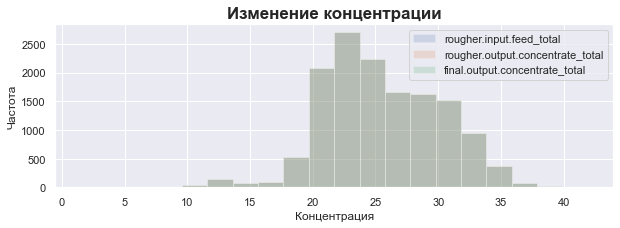

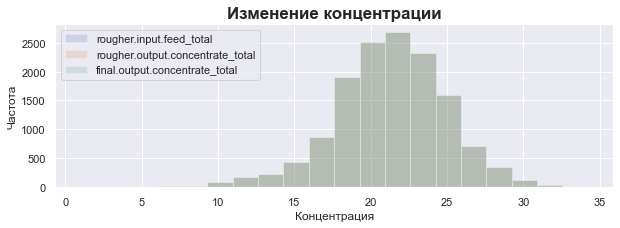

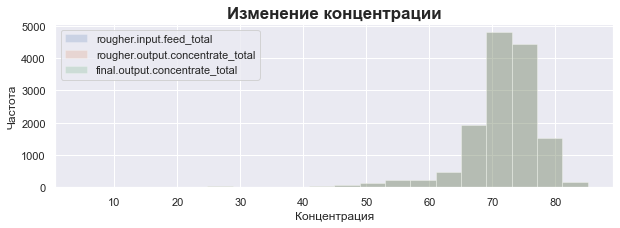

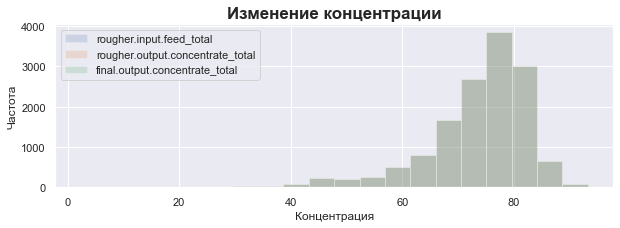

In [75]:
for sub in sub_names_list:
    sum_concentr_hist(df_train, sub)